# 05 - Execution Simulation: Order Matching Mechanics

Explore the mechanics of order matching engines and execution simulation. Understand limit/market orders, queue priority, latency, and how trades are executed or missed.


## Order Matching Engine Architecture
Below: Architecture diagram of a minimalist order book/matching engine.


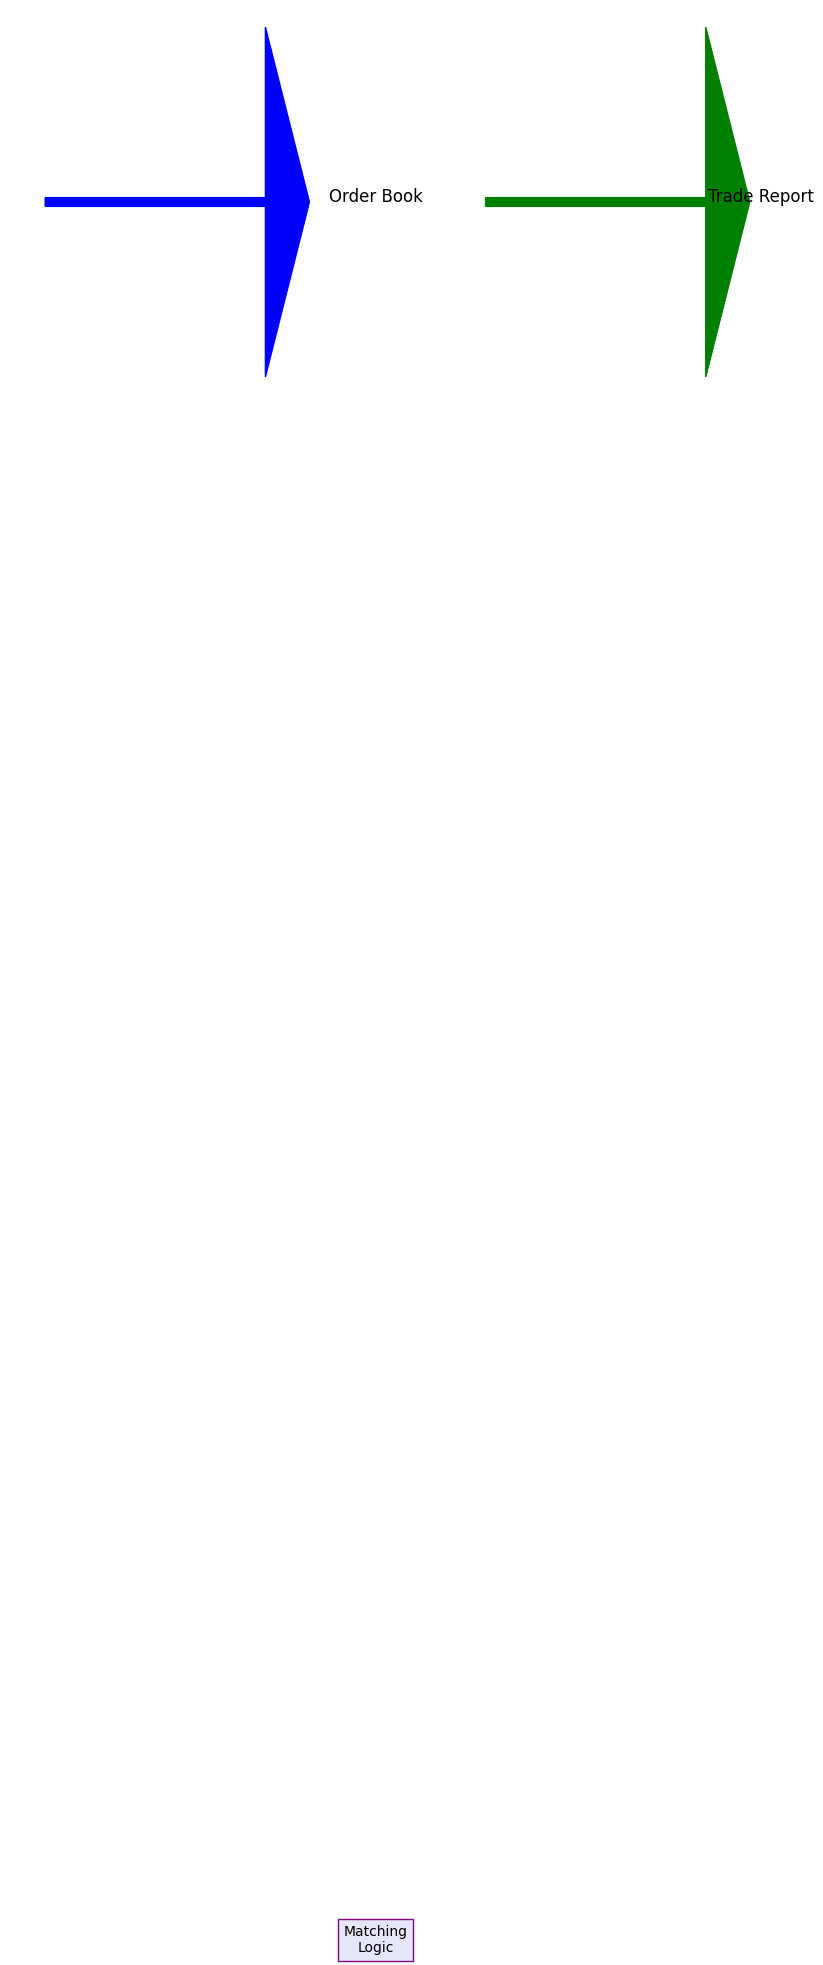

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
fig, ax = plt.subplots(figsize=(10, 5))
ax.axis('off')
ax.annotate('Order Received', (0.1, 0.7), fontsize=12, ha='center')
ax.annotate('Order Book', (0.5, 0.7), fontsize=12, ha='center')
ax.annotate('Trade Report', (0.85, 0.7), fontsize=12, ha='center')
ax.arrow(0.2, 0.7, 0.2, 0, head_width=0.04, head_length=0.04, color='blue')
ax.arrow(0.6, 0.7, 0.2, 0, head_width=0.04, head_length=0.04, color='green')
ax.text(0.5, 0.5, 'Matching\nLogic', ha='center', bbox=dict(facecolor='lavender', edgecolor='purple'))
plt.show()


## Basic Double Auction Order Book
Let's implement a minimal price/time-priority order book (bids/asks).

In [2]:
import heapq
from collections import deque

class Order:
    def __init__(self, id, side, price, qty, time):
        self.id = id
        self.side = side  # 'B' or 'S'
        self.price = price
        self.qty = qty
        self.time = time
    def __lt__(self, other):
        if self.price == other.price:
            return self.time < other.time
        return (self.price > other.price) if self.side=='B' else (self.price < other.price)

class OrderBook:
    def __init__(self):
        self.bids = []  # max-heap
        self.asks = []  # min-heap
        self.time = 0
        self.trades = []
    def add(self, side, price, qty):
        order = Order(id=len(self.bids)+len(self.asks)+1, side=side, price=price, qty=qty, time=self.time)
        self.time += 1
        if side == 'B':
            heapq.heappush(self.bids, order)
        else:
            heapq.heappush(self.asks, order)
        self.match()
    def match(self):
        while self.bids and self.asks and self.bids[0].price >= self.asks[0].price:
            buy, sell = heapq.heappop(self.bids), heapq.heappop(self.asks)
            qty = min(buy.qty, sell.qty)
            self.trades.append({'price': sell.price, 'qty': qty})
            if buy.qty > qty:
                buy.qty -= qty
                heapq.heappush(self.bids, buy)
            if sell.qty > qty:
                sell.qty -= qty
                heapq.heappush(self.asks, sell)

# Demo
ob = OrderBook()
ob.add('B', 100.0, 10)
ob.add('S', 99.0, 5)
ob.add('S', 100.0, 20)
print(ob.trades)

[{'price': 99.0, 'qty': 5}, {'price': 100.0, 'qty': 5}]


## Interactive Widget: Order Matching
Change order streams and parameters below to see execution results.

In [3]:
try:
    import ipywidgets as widgets
    from ipywidgets import interact_manual
    widgets_ok = True
except:
    widgets_ok = False

def simulate_orders(buy_price=100.0, buy_qty=10, sell_price=99.5, sell_qty=10):
    ob = OrderBook()
    ob.add('B', buy_price, buy_qty)
    ob.add('S', sell_price, sell_qty)
    print('Trades:', ob.trades)
    return ob.trades
if widgets_ok:
    interact_manual(simulate_orders, buy_price=(98,102,0.1), buy_qty=(1,20,1), sell_price=(98,102,0.1), sell_qty=(1,20,1))
else:
    simulate_orders()

interactive(children=(FloatSlider(value=100.0, description='buy_price', max=102.0, min=98.0), IntSlider(value=…

## Exercises
1. Extend the engine to track order queue position and FIFO priority.
2. Model latency and missed trades due to delays.
3. Support partial cancellations.
    

In [4]:
show_solutions = False
try:
    import ipywidgets as widgets
    btn = widgets.ToggleButton(value=False, description='Show Solutions')
    display(btn)
    def on_toggle(change):
        global show_solutions
        show_solutions = change['new']
    btn.observe(on_toggle, 'value')
except:
    pass
if show_solutions:
    print('Queue FIFO: store entered time on order, match lowest-entered order at each price.')
    print('Latency: delay order entry in time queue, match using time as arrival order.')
    print('Partial cancel: store live order refs, allow .qty reduction before match.')

ToggleButton(value=False, description='Show Solutions')

## Performance Benchmarks
We'll compare naive Python vs optimized batch insertion for large order books.

In [5]:
import time
import numpy as np
n_orders = 10000
np.random.seed(37)

orders = [(np.random.choice(['B','S']), 100+np.random.randn(), 1+np.random.randint(10)) for _ in range(n_orders)]
start = time.time()
ob = OrderBook()
for s, p, q in orders:
    ob.add(s, float(p), int(q))
print(f'Inserted {n_orders} orders in {time.time()-start:.2f}s')

Inserted 10000 orders in 0.03s


## Real-world Applications
- Core of exchange/ATS venue simulators
- Testing of market-making and latency arbitrage strategies
- Microstructure feature research using synthetic order books
- Realistic agent-based trading model development
